# pix2pix Gan 이란?
image to image translation에 해당하는 보편적인 목적을 이루기 위해서 고안해낸 모델이다. 

Gan 모델은 gernerator model과 discriminator model로 구성되어져 있다. 
- generaotr model은 그럴듯한 이미지(input 과는 다른 )를 생성해 내는 모델
- discriminator는  generator가 만든 model이 참인지 거짓인지를 판별해 내는 모델
이 두 모델은 서로 적대적인 관계로서 generator는 discriminator를 속이는 방향으로, discriminator는 속지 않으려는 방향으로 학습을 진행한다.(학습시, discriminator는 즉각적으로 update이 진행되며, generator는 discriminator를 통해 update된다.)

pix2pix Gan은 conditional Gan으로, 해당 경우는 원본 이미지가 condition이 된며, target(생성값)과 source(원본)를 discriminator는 분별해 내야만 한다. (추가적인 설명이 필요해 보인다.) 

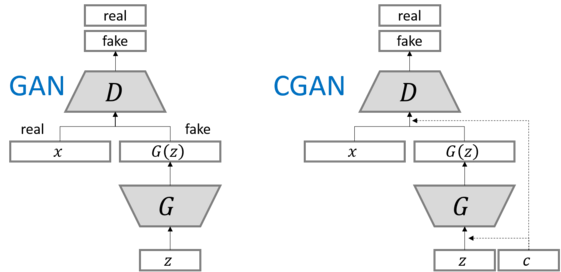

-출처:https://nooverfit.com/wp/wp-content/uploads/2017/10/Screenshot-from-2017-10-07-120039.png![Screenshot-from-2017-10-07-

Q)
- 위에서 z가 인공위성 이미지, x는 google map이미지, 그렇다면 c는 무엇인가? 

# Satellite -> Map Image Translation
제공되는 dataset은 특정 지역에 대한 위성 이미지와, 해당 지역에 상응하는 google 지도 이미지를 합친 이미지이다.
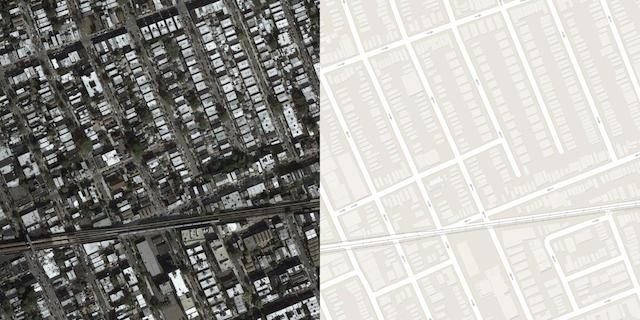 
JPEG 포멧이며, 각각의 이미지는 가로 1200, 세로 600 pixels로 구성되어 있으며 왼쪽이 위성, 오른쪽이 구글 지도 이미지에 해당한다.

원활한 학습을 위해 우리는 다음 dataset의 크기를 재 조정하고, 위성 이미지와 지도 이미지를 구별하여 서로 대응하는 1097개의 쌍을 만들어 낼 것이다.

In [ ]:
#load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

#데이터 업로드 
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load_img == 해당 경로의 이미지를 내가 정한 사이즈로 지정하는 함수
		pixels = load_img(path + filename, target_size=size) 
		# 저장한 이미지를 numpy array로 전환
		pixels = img_to_array(pixels)
		#절반씩으로 나누어서 위성이미지와 구글 지도 이미지로 분리.
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

#dataset path
path = 'maps/train/'
#load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
#save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

위의 과정을 거치고 나면, index 0번에는 인공위성 이미지가, index 1번에는 google 이미지가 저장되어 있는 배열인
maps_256.npz을 생성할 수 있다.(Numpy array를 압축한 형식)

In [ ]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# 데이터 로드 
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# 
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

잘 압축되었는지 일부만 출력해보는 코드

# Pix2pix model 학습
해당 모델은 discriminator 와 generator로 구성되어 있다.

## discriminator
discriminator는 이미지 분류를 실행하는 DNN이다. 정확하게는 conditional-image classification 으로 source(위성)와 target(google 지도)을 가지고 진짜인지, 가짜인지를 판별해낸다.
해당 모델에서는 PatchGan 모델을 사용하였는데, 이는 전체 이미지에 대해 얼마나 차이가 나는지를 확인하는 것이 아니라(Image Gan), 특정 크기의 patch 단위로 진짜/가짜를 구별하여 평균을 취하는 방식이다.
해당 모델의 결과물은 input의 크기에 따라 다르겠지만, 하나의 값이거나, 혹은 activation map일 것이다. 각각의 값들은 해당 path에 대해서 진짜일 확률을 나타내며, 이들의 펴윤은 전체적인 가능성을 나타낸다.

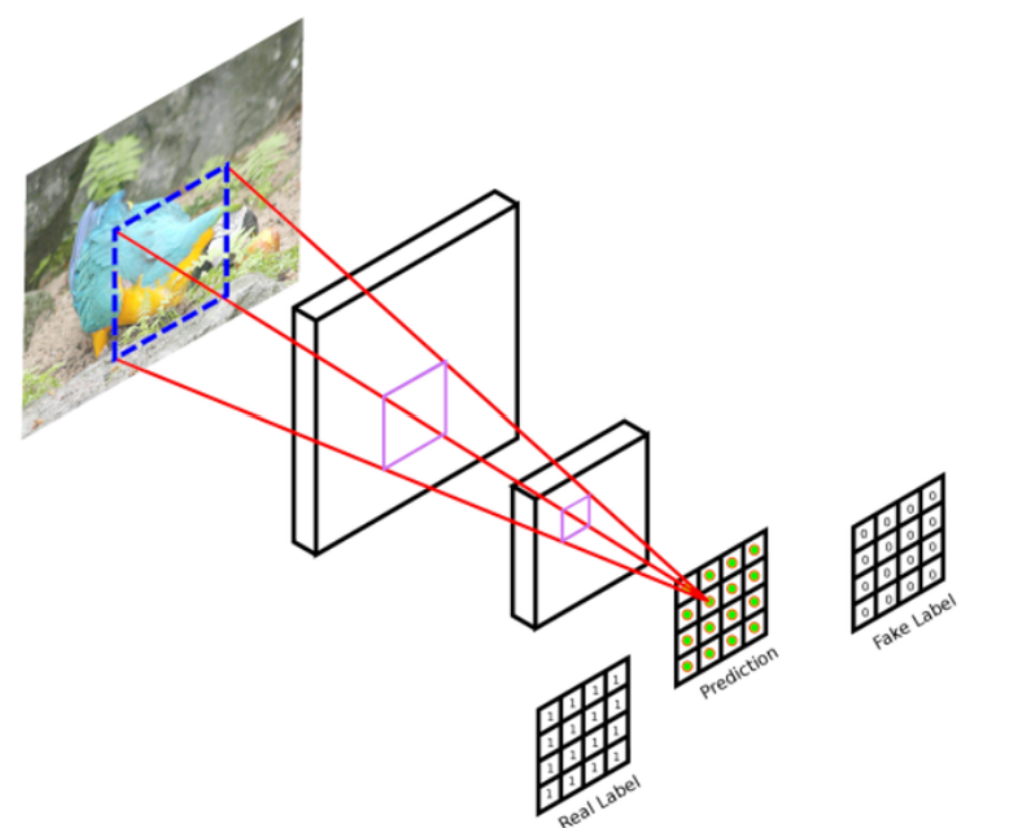
//pathGan이 유용한이유. 
픽셀들 간의 연관성은 거리에 비례해서 작아진다. 그러므로 픽셀간의 correlation 관계가 유지되는 범위에 해당하는 적절한 크기의 patch를 결정할 수 있다면 좀더 선명한 영상을 얻을 수 있게된다. 
또한 전체 pixel이 아닌 작은 patch에 대해서 sliding 방식으로 연산을 진행하기 때문에 파라미터의 개수가 적으며, 전체 크기에 영향을 받지 않기 때문에 조금더 유연하다는 장점을 가지고 있다.
//


Q) 
- patchGan은 그렇다면 patch의 위치는 어떻게 정하는가? 만약에 정했다면, discriminator에 들어가는 두개 모두의 input의 위치가 동일하게 들어가는가
- patchGan의 하나의 인풋에 대해서 단 하나의 patch를 적용해서 확인하는것인가?
- 적절한 크기의 path로 확인하는경우 더욱 선명한 이미지를 만들어 낼 수 있는 이유는? > 전체적으로 연관성이 떨어지는 pixel들관의 관계를 배제 할 수 있기 때문에?

- 출처: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=laonple&logNo=221366130381


In [ ]:

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization// 정규 분포에 따라 탠서를 생성하는 초기 설정기.
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model